# Compare Pangu-Weather and GFS with weather station data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc
import scipy
import cfgrib

from evaluation import collate_forecasts, format_ref_data

## Load station data

In [2]:
station_data = pd.read_csv('./data/gabrielle_obs.csv', parse_dates = ['TIME'])

In [3]:
napier_aero = station_data[station_data['NAME'] == 'NAPIER AERO AWS']
whitianga = station_data[station_data['NAME'] == 'WHITIANGA EWS']

In [4]:
whitianga

,TIME,NAME,AGENT_NO,LAT,LONGT,SFC_WIND_SPEED,SFC_WIND_DIRECTION,MSLP
1009,2023-02-05 00:00:00,WHITIANGA EWS,40981,-36.82817,175.67231,3.9,9,1017.4
1010,2023-02-05 01:00:00,WHITIANGA EWS,40981,-36.82817,175.67231,4.0,2,1017.0
1011,2023-02-05 02:00:00,WHITIANGA EWS,40981,-36.82817,175.67231,4.0,9,1016.5
1012,2023-02-05 03:00:00,WHITIANGA EWS,40981,-36.82817,175.67231,3.6,5,1016.2
1013,2023-02-05 04:00:00,WHITIANGA EWS,40981,-36.82817,175.67231,3.8,359,1015.9
...,...,...,...,...,...,...,...,...
1509,2023-02-25 20:00:00,WHITIANGA EWS,40981,-36.82817,175.67231,0.4,198,1019.6
1510,2023-02-25 21:00:00,WHITIANGA EWS,40981,-36.82817,175.67231,0.5,129,1019.5
1511,2023-02-25 22:00:00,WHITIANGA EWS,40981,-36.82817,175.67231,1.0,97,1019.6
1512,2023-02-25 23:00:00,WHITIANGA EWS,40981,-36.82817,175.67231,2.6,84,1019.3


In [5]:
napier_aero_location = {'latitude': napier_aero['LAT'][0], 'longitude': napier_aero['LONGT'][0]}
whitianga_location = {'latitude': whitianga['LAT'][1009], 'longitude': whitianga['LONGT'][1009]}

## Load simulation data

In [6]:
days = list(range(6, 16))

pg_forecasts_list = []
gfs_forecasts_list = []

for day in days:
    pg = xr.open_dataset(f'./data/pw-with-gfs-start/pw-202302{day:02d}T00.grib', engine='cfgrib')
    # Take the region around NZ
    subset_pg= pg.sel(latitude = slice(-25, -50), longitude = slice(165,185))
    # The data doesn't have the right time, so we need to relabel
    subset_pg.time.values = np.datetime64(f"2023-02-{day:02d}T00")
    pg_forecasts_list.append(subset_pg.drop_vars('valid_time'))
    
    gfs = xr.open_dataset(f'./data/gfs/gfs_processed_0p25_202302{day:02d}_00.nc')
    # relabel longitude of GFS data
    reassign_gfs = gfs.assign_coords(longitude = (gfs.longitude + 360) % 360).sortby('longitude')
    subset_gfs = reassign_gfs.sel(latitude = slice(-25, -50), longitude = slice(165,185))
    # Relabel by 'step' rather than by 'valid_time'
    steps = subset_gfs.step.values
    rename_gfs = subset_gfs.drop_vars('step').rename_vars({'prmsl':'msl'})
    relabel_gfs = rename_gfs.assign_coords({"valid_time":steps}).rename_dims({'valid_time':'step'}).rename({'valid_time':'step'})
    gfs_forecasts_list.append(relabel_gfs)

skipping variable: paramId==167 shortName='t2m'
Traceback (most recent call last):
  File "/scale_wlg_persistent/filesets/project/niwa00004/masonge/ai-models/venv/lib/python3.10/site-packages/cfgrib/dataset.py", line 680, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/scale_wlg_persistent/filesets/project/niwa00004/masonge/ai-models/venv/lib/python3.10/site-packages/cfgrib/dataset.py", line 611, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=10.0) new_value=Variable(dimensions=(), data=2.0)
/tmp/ipykernel_164311/1692643687.py:21: UserWarning: rename 'valid_time' to 'step' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  relabel_gfs = rename_gfs.assign_coords({"valid_time":steps}).rename_dims({'valid_time':'step'}).rename({'valid_time':'step'})
skipping va

In [7]:
# Drop variables we are not going to use before concatenation (for speed reasons; concat is slow).
new_pg_forecasts_list = []
for elt in pg_forecasts_list:
    new_pg_forecasts_list.append(elt.drop_vars(['z','q','t','u','v', 'isobaricInhPa']))
    
pg_forecasts = xr.concat(new_pg_forecasts_list, "time")
gfs_forecasts = xr.concat(gfs_forecasts_list, "time")

## Calculate error

In [8]:
# Convert hPa to Pa:
napier_aero['MSLP'] *= 100
whitianga['MSLP'] *= 100

/tmp/ipykernel_164311/1169599644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  napier_aero['MSLP'] *= 100
/tmp/ipykernel_164311/1169599644.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whitianga['MSLP'] *= 100


In [9]:
def get_uv(speed, direction):
    """Get u (zonal speed) and v (meridional speed) from wind speed and compass point direction."""
    u = -speed*np.cos((-direction + 90)*2*np.pi/360)
    v = -speed*np.sin((-direction + 90)*2*np.pi/360)
    return (u, v)

def format_station_data(dataframe):
    """Take the station data and make the variables, labels and indexing compatible with the formatted forecast data."""
    # Calculate meridional and zonal wind speeds:
    u, v = get_uv(dataframe.SFC_WIND_SPEED, dataframe.SFC_WIND_DIRECTION)
    return dataframe.assign(u10=u, v10=v).rename(columns={'TIME':'valid_time', 'MSLP':'msl'}).set_index("valid_time")

def forecast_at_station(forecast, location):
    """Interpolate the forecast to the station location. Put the resulting data into a Pandas 
    dataframe, and use valid_time as the index."""
    forecast_interp = forecast.interp(coords=location)
    df = forecast_interp.to_dataframe().reset_index().rename(columns={'time':'init_time'})
    reformat_df = df.assign(valid_time=df['init_time']+df['step']).set_index('valid_time')
    return reformat_df

def error_in_variable(forecast_station, formatted_station_data, variable):
    return (formatted_station_data[variable]-forecast_station[variable]).dropna().abs().to_frame(
                                            ).rename(columns={variable: variable + '_error'})

def add_error_to_df(forecast, station_data, location, variable_list):
    forecast_station = forecast_at_station(forecast, location)
    format_station = format_station_data(station_data)
    for variable in variable_list:
        forecast_station = pd.concat([forecast_station, error_in_variable(forecast_station, format_station, variable)], axis=1)
        
    return forecast_station

# def average_error(forecast_list, station_data, location, variable_list):
#     fc_with_errors = [add_error_to_df(forecast, station_data, location, variable_list) for forecast in forecast_list]
#     fc_errors = [forecast[[vbl + '_error' for vbl in variable_list]]for forecast in fc_with_errors]
#     return fc_errors.mean()


def error_over_lead_time(forecast_list, station_data, location, variable_list):

    fc_with_errors = [add_error_to_df(forecast, station_data, location, variable_list) for forecast in forecast_list]
    fc_errors_only = [ forecast[[vbl + '_error' for vbl in variable_list]+['step'] ].set_index(
                            'step') for forecast in fc_with_errors]
    
    rmses = []
    for vbl in variable_list:
        if vbl == 'u10' or vbl == 'v10':
            continue # calculate wind separately
        # Calculate RMSE in this variable
        error = np.sqrt(sum([forecast[vbl+'_error']**2 for forecast in fc_errors_only])/len(variable_list))
        rmses.append(error)
        
    wind_error = np.sqrt(sum([forecast['u10_error']**2 for forecast in fc_errors_only]) +
                    sum([forecast['v10_error']**2 for forecast in fc_errors_only]))/len(variable_list)
    rmses.append(wind_error)
        
    return rmses



In [10]:


pg_errors_napier_aero = error_over_lead_time(new_pg_forecasts_list, napier_aero, napier_aero_location, ['msl', 'u10', 'v10'])
gfs_errors_napier_aero = error_over_lead_time(gfs_forecasts_list, napier_aero, napier_aero_location, ['msl', 'u10', 'v10'])

In [11]:
pg_errors_whitianga = error_over_lead_time(new_pg_forecasts_list, whitianga, whitianga_location, ['msl', 'u10', 'v10'])
gfs_errors_whitianga = error_over_lead_time(gfs_forecasts_list, whitianga, whitianga_location, ['msl', 'u10', 'v10'])

## Plot

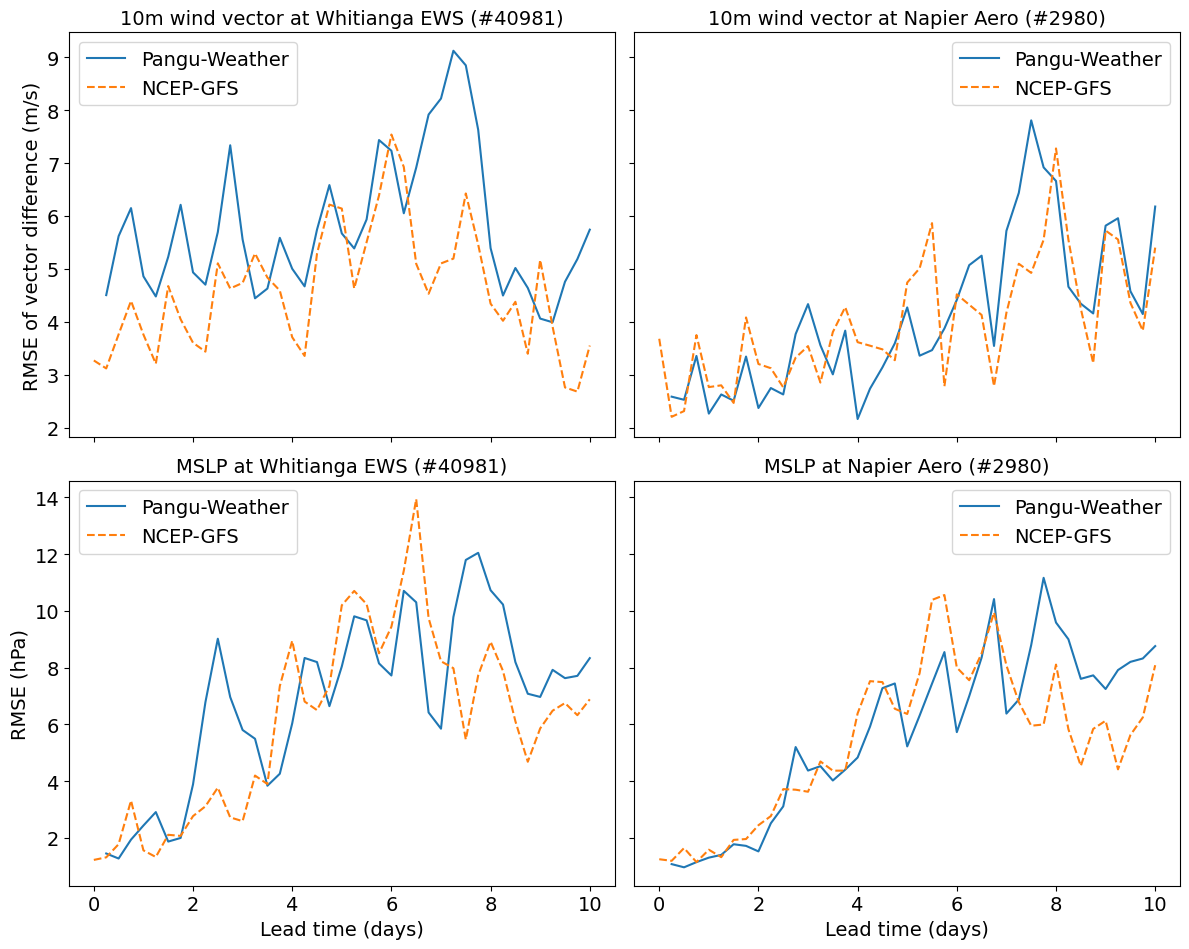

In [12]:
# Create a 2x2 grid of subplots, sharing y-axis within each row and x-axis within each column
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey='row', sharex='col')

msl_scale = 100 # Use hectopascals instead of pascals.

x_axis_pg = pg_errors_whitianga[1].index / np.timedelta64(1, 'D')  # Convert timedelta index to days
x_axis_gfs = gfs_errors_whitianga[1].index / np.timedelta64(1, 'D')  # Convert timedelta index to days

# Define font sizes
title_fontsize = 14
label_fontsize = 14
tick_fontsize = 14
legend_fontsize = 14

# Plot for Whitianga wind
axs[0, 0].plot(x_axis_pg, pg_errors_whitianga[1], label="Pangu-Weather")
axs[0, 0].plot(x_axis_gfs, gfs_errors_whitianga[1], linestyle='--', label="NCEP-GFS")  # Dotted line for GFS
axs[0, 0].set_title(f"""10m wind vector at Whitianga EWS (#40981)""", fontsize=title_fontsize)
# axs[0, 0].set_title(f"""10m wind vector at Whitianga EWS (#40981)
# Average RMSE (Pangu-Weather) = {pg_errors_whitianga[1].mean():1.2f}
# Average RMSE (NCEP-GFS) = {gfs_errors_whitianga[1].mean():1.2f}""", fontsize=title_fontsize, ha = 'left', x = 0)
axs[0, 0].set_ylabel('RMSE of vector difference (m/s)', fontsize=label_fontsize)
axs[0, 0].legend(fontsize=legend_fontsize)
axs[0, 0].tick_params(axis='both', labelsize=tick_fontsize)

# Plot for Whitianga MSLP
axs[1, 0].plot(x_axis_pg, pg_errors_whitianga[0]/msl_scale, label="Pangu-Weather")
axs[1, 0].plot(x_axis_gfs, gfs_errors_whitianga[0]/msl_scale, linestyle='--', label="NCEP-GFS")  # Dotted line for GFS
axs[1, 0].set_title(f"""MSLP at Whitianga EWS (#40981)""", fontsize=title_fontsize)
# axs[1, 0].set_title(f"""MSLP at Whitianga EWS (#40981)
# Average RMSE (Pangu-Weather) = {pg_errors_whitianga[0].mean()/msl_scale:1.2f}
# Average RMSE (NCEP-GFS) = {gfs_errors_whitianga[0].mean()/msl_scale:1.2f}""", fontsize=title_fontsize, ha = 'left', x=0)
axs[1, 0].set_xlabel('Lead time (days)', fontsize=label_fontsize)
axs[1, 0].set_ylabel('RMSE (hPa)', fontsize=label_fontsize)
axs[1, 0].legend(fontsize=legend_fontsize)
axs[1, 0].tick_params(axis='both', labelsize=tick_fontsize)

# Plot for Napier Airport wind
axs[0, 1].plot(x_axis_pg, pg_errors_napier_aero[1], label="Pangu-Weather")
axs[0, 1].plot(x_axis_gfs, gfs_errors_napier_aero[1], linestyle='--', label="NCEP-GFS")  # Dotted line for GFS
axs[0, 1].set_title(f"""10m wind vector at Napier Aero (#2980)""", fontsize=title_fontsize)
# axs[0, 1].set_title(f"""10m wind vector at Napier Aero (#2980)
# Average RMSE (Pangu-Weather) = {pg_errors_napier_aero[1].mean():1.2f}
# Average RMSE (NCEP-GFS) = {gfs_errors_napier_aero[1].mean():1.2f}""", fontsize=title_fontsize, ha = 'left', x=0)
axs[0, 1].legend(fontsize=legend_fontsize)
axs[0, 1].tick_params(axis='both', labelsize=tick_fontsize)

# Plot for Napier Airport MSLP
axs[1, 1].plot(x_axis_pg, pg_errors_napier_aero[0]/msl_scale, label="Pangu-Weather")
axs[1, 1].plot(x_axis_gfs, gfs_errors_napier_aero[0]/msl_scale, linestyle='--', label="NCEP-GFS")  # Dotted line for GFS
axs[1, 1].set_title(f"""MSLP at Napier Aero (#2980)""", fontsize=title_fontsize)
# axs[1, 1].set_title(f"""MSLP at Napier Aero (#2980)
# Average RMSE (Pangu-Weather) = {pg_errors_napier_aero[0].mean()/msl_scale:1.2f}
# Average RMSE (NCEP-GFS) = {gfs_errors_napier_aero[0].mean()/msl_scale:1.2f}""", fontsize=title_fontsize, ha = 'left', x=0)
axs[1, 1].set_xlabel('Lead time (days)', fontsize=label_fontsize)
axs[1, 1].legend(fontsize=legend_fontsize)
axs[1, 1].tick_params(axis='both', labelsize=tick_fontsize)

# # Add a super title
# plt.suptitle("""Error comparison with weather station data over Ex-Tropical Cyclone Gabrielle
# Validation period: 2023/02/06 00 - 2023/02/25 00 UTC
# Model initialization: every 24 hours from 2023/02/06 00 - 2023/02/15 00 UTC (10 forecasts)""", fontsize=16, ha = 'left', x=0.1)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rect to make room for suptitle

plt.rcParams['font.stretch'] = 'condensed'

# Save the figure
plt.savefig('./figures/station_data_comparison.png')

# Show the figure
plt.show()